
# Results

| Configuration                              | Accuracy |
|--------------------------------------------|----------|
| Custom CNN                                 | 87.18    |
| Custom CNN + Data Augmentation             | **90.22**    |
| Resnet18 Frozen                            | 84.46    |
| Resnet18 Full Finetune                     | 86.22    |
| Resnet18 Full Finetune + Data Augmentation | 88.62    |
| Resnet50 Frozen                            | 83.65    |
| Resnet50 Full Finetune                     | 86.70    |
| Resnet50 Full Finetune + Data Augmentation | 87.18    |


# Observations

* Smaller models tend to work better
* Random Horizontal Flip data augmentation technique consistently improves results
* More hyper-parameter tuning needed

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=ecf3b57068a65dead75978d2b86a4ae19ba9552cc041b34cc444222bbf3f38dd
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as vision_models
from torchvision.transforms import Compose, Normalize, ToTensor
import medmnist
from medmnist import INFO
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import numpy as np
from torchvision.transforms import RandomHorizontalFlip

In [ ]:
random.seed(19)
# torch.cuda.manual_seed(19) if torch.cuda.is_available() else torch.manual_seed(19)
BATCH_SIZE = 256
FREEZE_PRETRAINED_EXTRACTOR = False  # for freeze = true, the model will be pretrained, for freeze=false, we train the model again
NUM_EPOCHS = 5
lr = 1e-3 if FREEZE_PRETRAINED_EXTRACTOR else 1e-4
USE_DATA_AUGMENTATION = True
USE_CUSTOM_BACKBONE = False
if USE_CUSTOM_BACKBONE:
  NUM_EPOCHS = 10
  lr = 1e-3
if FREEZE_PRETRAINED_EXTRACTOR:
  NUM_EPOCHS = 10

Information on PneumoniaMNIST dataset

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pne

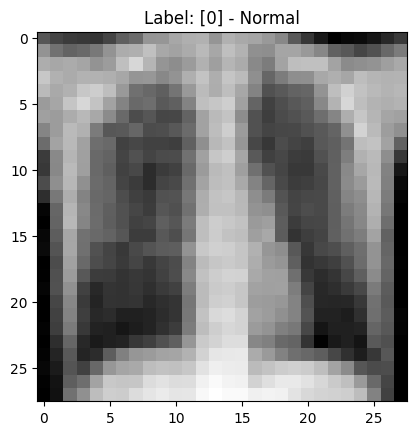

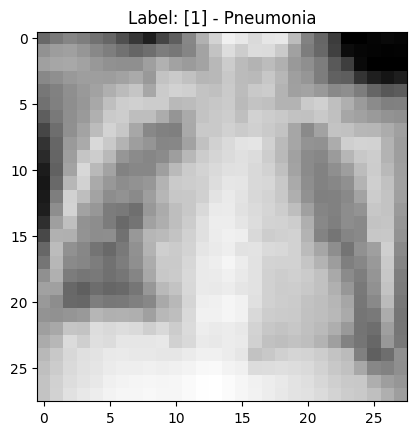

In [ ]:
data_flag = "pneumoniamnist"
info = INFO[data_flag]
task = info["task"]
n_channels = info["n_channels"]
n_classes = len(info["label"])
download = True

DataClass = getattr(medmnist, info["python_class"])

data_transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
train = DataClass(split="train", transform=data_transform, download=download)
val = DataClass(split="val", transform=data_transform, download=download)
test = DataClass(split="test", transform=data_transform, download=download)

print(train)
print("===================")
print(val)
print("===================")
print(test)


############## Print exemplary normal and pneumonia images ##############

normal_indices = [i for i, label in enumerate(train.labels) if label == [0]]
pneumonia_indices = [i for i, label in enumerate(train.labels) if label == [1]]

selected_normal_index = normal_indices[0] # Select the first image with 'normal' label
selected_pneumonia_index = pneumonia_indices[0] # Select the first image with 'pneumonia' label

image0, label0 = train[selected_normal_index]
image0_array = np.array(image0.squeeze())
plt.imshow(image0_array, cmap='gray')
plt.title(f'Label: {label0} - Normal')

plt.show()

image1, label1 = train[selected_pneumonia_index]
image1_array = np.array(image1.squeeze())
plt.imshow(image1_array, cmap='gray')
plt.title(f'Label: {label1} - Pneumonia')

plt.show()

Define dataloaders for PneumoniaMNIST

In [ ]:
def get_data_loaders(train_batch_size, val_batch_size, test_batch_size):
    data_transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    if USE_DATA_AUGMENTATION:
      train_data_transform = Compose([ToTensor(), RandomHorizontalFlip(), Normalize((0.5,), (0.5,))])
    else:
      train_data_transform = data_transform
    train = DataClass(split="train", transform=train_data_transform, download=download)
    val = DataClass(split="val", transform=data_transform, download=download)
    test = DataClass(split="test", transform=data_transform, download=download)
    pil_dataset = DataClass(split="train", download=download)
    train_loader = DataLoader(
        train,
        num_workers=1,
        batch_size=train_batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val, num_workers=1, batch_size=val_batch_size, shuffle=False
    )

    test_loader = DataLoader(
        test, num_workers=1, batch_size=test_batch_size, shuffle=False
    )

    return train_loader, val_loader, test_loader

Model(s) for binary classification. The first class is a pretrained residual network, while the second is a custom convolutional network. Both classes perform feature extraction. The last class performs the classification. For our implementations, we opted for the ResNet, due to a slightly better accuracy in the test set.

In [ ]:
class PretrainedBackbone(nn.Module):
    def __init__(self, in_channels, original_model=None, freeze_extractor=True):
        super(PretrainedBackbone, self).__init__()
        self.in_channels = in_channels
        if original_model is None:
            original_model = vision_models.resnet18(pretrained=True)
            # original_model = vision_models.resnet50(pretrained=True)
        self.features = nn.Sequential(
            *list(original_model.children())[:-3]
        )  # get the whole model for feature extraction, apart from the last 3 layers
        for i, p in enumerate(self.features.parameters()):
            p.requires_grad = not freeze_extractor

        self.out_size = 1024
        # self.out_size = 1024 * 2 * 2

    def forward(self, x):
        x = self.features(x.repeat(1, 3, 1, 1)).view(x.size(0), -1) # tailor it to the 28x28 images

        return x

In [ ]:
class CustomBackbone(nn.Module):
    def __init__(self, in_channels):
        super(CustomBackbone, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3), nn.BatchNorm2d(16), nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3), nn.BatchNorm2d(64), nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3), nn.BatchNorm2d(64), nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.feat_extractor = nn.Sequential(
            self.layer1, self.layer2, self.layer3, self.layer4, self.layer5
        )

        self.out_size = 64 * 4 * 4

    def forward(self, x):
        return self.feat_extractor(x).view(x.size(0), -1)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, backbone, num_classes=1):
        super(Classifier, self).__init__()
        self.backbone = backbone
        self.clf = nn.Linear(backbone.out_size, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        out = self.clf(feats)
        return out

Now we train, evaluate and test our clssifier. The function for the train subset is given separately from the validation and test subsets.

In [ ]:
def train_epoch(
    model, optimizer, criterion, train_loader, epoch, device="cpu"
):

    train_iter = tqdm(train_loader, desc="training", leave=True)

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    n_count = 0

    for idx, (inputs, labels) in enumerate(train_iter):
        inputs = inputs.to(device)
        labels = labels.to(device)
        n_count += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.to(torch.float32)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = (outputs.squeeze() > 0.5).long()
        labels = labels.squeeze()
        total_train += labels.size(0)

        correct_train += (preds == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = train_loss / n_count
    return train_loss, train_accuracy

In [ ]:
def eval_epoch(
    model, criterion, eval_loader, epoch=None, device="cpu"
):
    eval_iter = tqdm(
        eval_loader, desc="validation" if epoch is not None else "test", leave=True
    )

    all_predictions = []
    all_labels = []
    model.eval()
    correct_eval = 0
    total_eval = 0
    eval_loss = 0
    n_count = 0

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(eval_iter):
            n_count += 1
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            preds = (outputs.squeeze() > 0.5).long()
            labels = labels.squeeze()

            # for the scikit metrics
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.float().cpu().numpy())

            total_eval += labels.size(0)
            correct_eval += (preds == labels).sum().item()

    eval_accuracy = correct_eval / total_eval
    eval_loss = eval_loss / n_count

    return eval_loss, eval_accuracy, all_predictions, all_labels

We iterate over all epochs.

In [ ]:
def train(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs,
    device="cpu",
):

    num_epochs = epochs

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    val_losses = []

    for e in range(num_epochs):

        ############### TRAIN ###############

        epoch_train_loss, epoch_train_acc = train_epoch(
            model,
            optimizer,
            criterion,
            train_loader,
            e,
            device=device,
        )
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        print(
            f"Epoch {e+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Training Accuracy: {epoch_train_acc}"
        )

        ############### VALIDATION ###############

        epoch_val_loss, epoch_val_acc, _, _ = eval_epoch(
            model, criterion, val_loader, epoch=e, device=device
        )
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(
            f"Epoch {e+1}/{num_epochs}, Val Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_acc}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

We put everything together...

cuda
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
training: 100%|██████████| 19/19 [00:01<00:00, 13.08it/s]


Epoch 1/5, Train Loss: 0.453821378318887, Training Accuracy: 0.7289719626168224


validation: 100%|██████████| 3/3 [00:00<00:00, 13.11it/s]


Epoch 1/5, Val Loss: 0.30591169993082684, Validation Accuracy: 0.8854961832061069


training: 100%|██████████| 19/19 [00:01<00:00, 11.68it/s]


Epoch 2/5, Train Loss: 0.17138842218800596, Training Accuracy: 0.9513593882752761


validation: 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]


Epoch 2/5, Val Loss: 0.2570931911468506, Validation Accuracy: 0.9045801526717557


training: 100%|██████████| 19/19 [00:01<00:00, 11.55it/s]


Epoch 3/5, Train Loss: 0.0967964286866941, Training Accuracy: 0.9683517417162277


validation: 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]


Epoch 3/5, Val Loss: 0.08429976056019466, Validation Accuracy: 0.9732824427480916


training: 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


Epoch 4/5, Train Loss: 0.0763148371326296, Training Accuracy: 0.9751486830926084


validation: 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


Epoch 4/5, Val Loss: 0.07644292463858922, Validation Accuracy: 0.9675572519083969


training: 100%|██████████| 19/19 [00:01<00:00, 12.10it/s]


Epoch 5/5, Train Loss: 0.057901459500977866, Training Accuracy: 0.9847068819031436


validation: 100%|██████████| 3/3 [00:00<00:00, 13.28it/s]


Epoch 5/5, Val Loss: 0.10904414455095927, Validation Accuracy: 0.9675572519083969


test: 100%|██████████| 3/3 [00:00<00:00, 12.79it/s]


Test Loss: 0.32137303551038104	Test accuracy: 0.8862179487179487


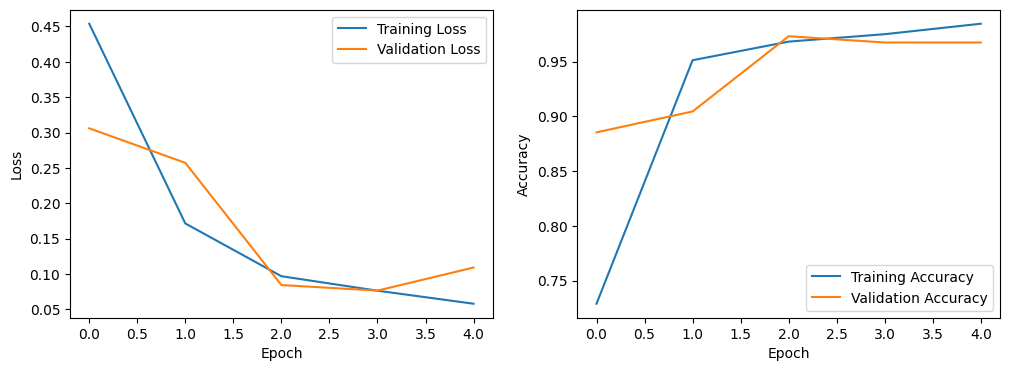

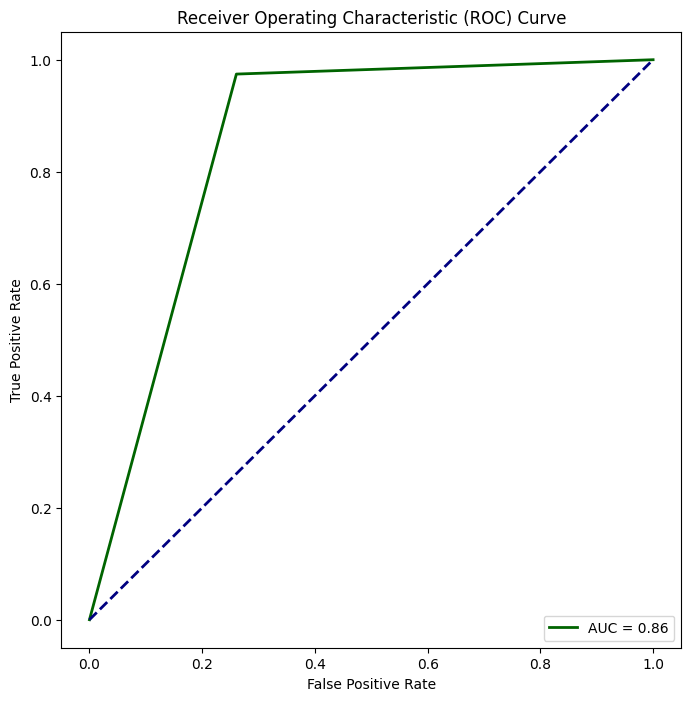

AUC Score: 0.86
Final Accuracy: 0.8862179487179487
Confusion Matrix:
[[173  61]
 [ 10 380]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83       234
         1.0       0.86      0.97      0.91       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.87       624
weighted avg       0.89      0.89      0.88       624



In [ ]:
random.seed(19)
if torch.cuda.is_available():
  torch.cuda.manual_seed(19)
  torch.backends.cudnn.deterministic=True
  np.random.seed(19)
  device = "cuda"
else:
  torch.manual_seed(19)
  np.random.seed(19)
  device = "cpu"

print(device)

train_loader, val_loader, test_loader = get_data_loaders(
    BATCH_SIZE, BATCH_SIZE, BATCH_SIZE
)

if USE_CUSTOM_BACKBONE:
  backbone = CustomBackbone(n_channels)
else:
  backbone = PretrainedBackbone(
    n_channels, freeze_extractor=FREEZE_PRETRAINED_EXTRACTOR
  )

model = Classifier(backbone, num_classes=1)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)

epochs = NUM_EPOCHS

train_losses, train_accuracies, val_losses, val_accuracies = train(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs,
    device=device,
)

test_loss, test_accuracies, all_preds, all_labels = eval_epoch(
    model, criterion, test_loader, epoch=None, device=device
)
print(f"Test Loss: {test_loss}\tTest accuracy: {test_accuracies}")

# We plot the learning curves and calculate typical classification metrics

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Compute Area Under the Curve (AUC)
auc_score = roc_auc_score(all_labels, all_preds)

# Compute Receiver Operating Characteristics (ROC)
fpr, tpr, _ = roc_curve(all_labels, all_preds)

# Compute final accuracy, confusion matrix and produce a classification report
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC Score: {auc_score:.2f}')
print(f"Final Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")